# **Predictor Básico de Proteínas Moonlighting**
En este notebook, construiremos y entrenaremos un clasificador para secuencias de proteínas moonlighting utilizando el modelo ProstT5. Nuestro objetivo es demostrar cómo el deep learning puede ser utilizado para clasificar secuencias basadas en sus anotaciones funcionales. Este ejercicio servirá como una introducción al manejo de datos de proteínas y a la aplicación de técnicas avanzadas de procesamiento de lenguaje natural en bioinformática, específicamente para proteínas moonlighting.


In [1]:
import torch
import torch.nn as nn
from transformers import T5Tokenizer, T5EncoderModel
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import seaborn as sns

import torch.optim as optim

# Verificamos si CUDA está disponible; si no lo está, lanzamos una excepción
# para garantizar que el script se ejecute en una GPU.
if not torch.cuda.is_available():
    raise Exception("CUDA no está disponible. Este script requiere una GPU con CUDA para un procesamiento eficiente.")
device = torch.device("cuda")


/data/users/rodalex/software/miniconda3/envs/prot_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Clasificador de proteínas
Nuestro clasificador de proteínas está diseñado como un modelo secuencial que utiliza embeddings de secuencias proteicas, procesándolos a través de varias capas para predecir si una secuencia es moonlighting o no.

Nota: los embeddings son representaciones numéricas densas que capturan características relevantes de los datos en un espacio de menor dimensión.


In [2]:
class ProteinClassifier(nn.Module):
    def __init__(self):
        super(ProteinClassifier, self).__init__()
        # Definimos la arquitectura del clasificador.
        self.classifier = nn.Sequential(
            nn.Linear(1024, 128),  # Tamaño de entrada basada en el embedding T5.
            nn.ReLU(),             # Función de activación para añadir no linealidad.
            nn.Dropout(0.1),       # Capa de dropout para reducir el sobreajuste,
            nn.Linear(128, 1)      # Salida binaria para la clasificación.
        ).to(device)  # Garantizamos que el modelo use la GPU.

    def forward(self, embeddings):
        # Pasamos los embeddings por el clasificador para obtener los logits
        # (valores de salida sin normalizar de un modelo antes de aplicar una
        # función de activación como softmax).
        logits = self.classifier(embeddings)
        return logits

## Manejo de datos
Para entrenar y evaluar nuestro modelo, cargaremos datos desde un archivo CSV, los dividiremos en conjuntos de entrenamiento y prueba, y crearemos nuestros objetos de dataset. La clase `ProteinDataset` se encarga de procesar y tokenizar las secuencias de proteínas, generar embeddings con el modelo ProstT5, y almacenar los embeddings resultantes junto con sus etiquetas correspondientes.


In [3]:
class ProteinDataset(Dataset):
    def __init__(self, dataframe, model_name='Rostlab/ProstT5', device='cpu', mode='seq'):
        self.dataframe = dataframe
        self.embeddings = []
        self.labels = []
        tokenizer = T5Tokenizer.from_pretrained(model_name, do_lower_case=False)
        model = T5EncoderModel.from_pretrained(model_name).to(device)
        model.eval()

        with torch.no_grad():
            for _, row in dataframe.iterrows():
                sequence = row[mode]
                label = row['Class']

                # Preprocesamiento y tokenización.
                sequence_processed = " ".join(list(re.sub(r"[UZOB]", "X", sequence)))
                sequence_processed = "<AA2fold> " + sequence_processed if sequence_processed.isupper() else "<fold2AA> " + sequence_processed
                inputs = tokenizer(sequence_processed, return_tensors="pt", padding=True, truncation=True,
                                   max_length=512, add_special_tokens=True).to(device)

                # Generación de embeddings.
                outputs = model(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask)
                embeddings = outputs.last_hidden_state.mean(dim=1)

                self.embeddings.append(embeddings.cpu().numpy())  # Almacenado como numpy para reducir el uso de memoria.
                self.labels.append(label)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Convertir de numpy a tensor cuando se accede.
        return torch.tensor(self.embeddings[idx]), torch.tensor(self.labels[idx], dtype=torch.float)

## Preparación del Conjunto de Datos
En esta sección, preparamos el conjunto de datos y definimos las secuencias de aminoácidos que analizaremos. Este proceso generará embeddings, lo cual puede llevar unos minutos.

Primero, seleccionamos las secuencias de interés. Luego, creamos los conjuntos de datos de entrenamiento y prueba, y preparamos los cargadores de datos para el entrenamiento y evaluación del modelo.


In [6]:
%ls ..

BaseLineNotebooks/          get_embeddings_emc3.ipynb     prott5_embeddings.npy
emmaemb_pla2g2.ipynb        LICENSE                       sentencepiece/
get_embedding_prott5.ipynb  prott5_attention_weights.npy  train_model.ipynb


In [ ]:
# Load CSV file (assumes columns: "id" and "sequence")
df = pd.read_csv("predictor_dataset.csv")

# Convert to dictionary using sequences as keys
sequences = df["Amino Acid Sequence"].unique()  # Ensure sequences are unique

print(f"Total Sequences: {len(df['Amino Acid Sequence'])} Total Sequences unique: {len(sequences)}")
print(f"Unique UniProt IDs {len(df['UniProt IDs'].unique())}")
print(f"Unique PDB IDs {len(df['PDB ID'].unique())}")


# Assuming df is your DataFrame
duplicate_sequences = df["Amino Acid Sequence"].value_counts()
duplicate_sequences = duplicate_sequences[duplicate_sequences > 1]

# Print the number of repetitions for each duplicated sequence
print("Finding Duplicated Sequences")
for sequence, count in duplicate_sequences.items():
    print(f"Repetitions: {count}, Sequence: {sequence}")

# Find Same Sequences with Different IDs
duplicates = df[df.duplicated(subset=["Amino Acid Sequence"], keep=False)]
print(duplicates[['Class', 'UniProt IDs', 'PDB ID', 'Amino Acid Sequence']].sort_values("Amino Acid Sequence"))

# Count occurrences of each sequence
sequence_counts = df["Amino Acid Sequence"].value_counts()

# Filter to keep only sequences that appear exactly once
unique_sequences = sequence_counts[sequence_counts == 1].index

# Keep only rows where the sequence appears exactly once
df_unique = df[df["Amino Acid Sequence"].isin(unique_sequences)]

# Save the cleaned dataset
df_unique.to_csv("filtered_dataset.csv", index=False)

print("Remove all copies of sequences that appear multiple times")
print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(df_unique)}")
print(f"Filtered dataset #Uniprot IDs: {len(df_unique['UniProt IDs'].unique())}")
print(f"Moonlight proteins rate in the unique dataset: {len(df_unique[df_unique['Class'] == True])*100 / len(df_unique)} %")

In [7]:
df_literature = pd.read_csv("../../DATASETS/predictor_dataset.csv")
mode = "Amino Acid Sequence"

## Aquí puedes estratificar.
df_train, df_test = train_test_split(df_literature, test_size=0.2, random_state=42, stratify=df_literature['Class'])
train_dataset = ProteinDataset(df_train, mode=mode, device=device)
test_dataset = ProteinDataset(df_test, mode=mode, device=device)

# Creamos los cargadores de datos.
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## Bucle de entrenamiento
En esta sección, realizaremos el entrenamiento de nuestro clasificador de proteínas a través de múltiples épocas. Seguiremos con una fase de validación para monitorear el rendimiento del modelo en datos no vistos. El siguiente bloque de código detalla el bucle completo de entrenamiento y validación, incluyendo el seguimiento de la pérdida y precisión en ambas fases a lo largo de las épocas.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def setup_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ProteinClassifier().to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-5)
    loss_fn = nn.BCEWithLogitsLoss()
    return model, optimizer, loss_fn, device

def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss, correct_predictions, total_predictions = 0, 0, 0
    for sequences, labels in dataloader:
        sequences, labels = sequences.to(device), labels.to(device).float().unsqueeze(-1)
        optimizer.zero_grad()
        logits = model(sequences).squeeze(-1)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.sigmoid(logits) >= 0.5
        correct_predictions += (preds == labels.bool()).sum().item()
        total_predictions += labels.size(0)
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

def validate_one_epoch(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, correct_predictions, total_predictions = 0, 0, 0
    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences, labels = sequences.to(device), labels.to(device).float().unsqueeze(-1)
            logits = model(sequences).squeeze(-1)
            loss = loss_fn(logits, labels)
            total_loss += loss.item()
            preds = torch.sigmoid(logits) >= 0.5
            correct_predictions += (preds == labels.bool()).sum().item()
            total_predictions += labels.size(0)
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

def train_and_validate(model, train_dataloader, test_dataloader, optimizer, loss_fn, device, num_epochs):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_dataloader, optimizer, loss_fn, device)
        val_loss, val_accuracy = validate_one_epoch(model, test_dataloader, loss_fn, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print(f'Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    return train_losses, val_losses, train_accuracies, val_accuracies

def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(16, 8))

    # Gráfico de pérdidas
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=22)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=22)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.tight_layout()
    plt.show()

def evaluate_and_plot_confusion_matrix(model, dataloader, device):
    model.eval()  # Configuramos el modelo para modo de evaluación.
    all_preds, all_labels = [], []

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device).float().unsqueeze(-1)
            logits = model(sequences).squeeze(-1)
            preds = torch.sigmoid(logits) >= 0.5  # Convertimos los logits a predicciones binarias.

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generamos la matriz de confusión.
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()

    # Calculamos la especificidad.
    specificity = tn / (tn + fp)

    # Calculamos el estadístico Kappa.
    kappa = cohen_kappa_score(all_labels, all_preds)

    # Representamos la matriz de confusión.
    plt.figure(figsize=(12, 8))  # Aumenta el tamaño de la figura
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
                annot_kws={"size": 24})
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)
    plt.title('Confusion Matrix', fontsize=22)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

    # Cálculo de métricas adicionales para evaluar el modelo.
    metrics = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'])
    print("\nMétricas de Evaluación:")
    print(metrics)
    print(f"Especificidad: {specificity:.4f}")
    print(f"Estadístico Kappa: {kappa:.4f}")

### Entrenamiento y evaluación del modelo
Inicializamos el modelo, configuramos el optimizador y la función de pérdida, y realizamos el entrenamiento y validación del modelo a lo largo de múltiples épocas. Al finalizar, visualizamos los resultados obtenidos mediante gráficos de pérdidas y precisiones, complementados con una matriz de confusión para evaluar el rendimiento del modelo.


Epoch 1, Training Loss: 0.6895, Validation Loss: 0.6876, Training Accuracy: 0.5615, Validation Accuracy: 0.5850
Epoch 2, Training Loss: 0.6826, Validation Loss: 0.6821, Training Accuracy: 0.6161, Validation Accuracy: 0.6285
Epoch 3, Training Loss: 0.6754, Validation Loss: 0.6764, Training Accuracy: 0.6538, Validation Accuracy: 0.6403
Epoch 4, Training Loss: 0.6675, Validation Loss: 0.6695, Training Accuracy: 0.6587, Validation Accuracy: 0.6640
Epoch 5, Training Loss: 0.6584, Validation Loss: 0.6625, Training Accuracy: 0.6677, Validation Accuracy: 0.6640
Epoch 6, Training Loss: 0.6492, Validation Loss: 0.6556, Training Accuracy: 0.6855, Validation Accuracy: 0.6561
Epoch 7, Training Loss: 0.6399, Validation Loss: 0.6484, Training Accuracy: 0.6885, Validation Accuracy: 0.6601
Epoch 8, Training Loss: 0.6308, Validation Loss: 0.6425, Training Accuracy: 0.6895, Validation Accuracy: 0.6719
Epoch 9, Training Loss: 0.6223, Validation Loss: 0.6354, Training Accuracy: 0.6935, Validation Accuracy:

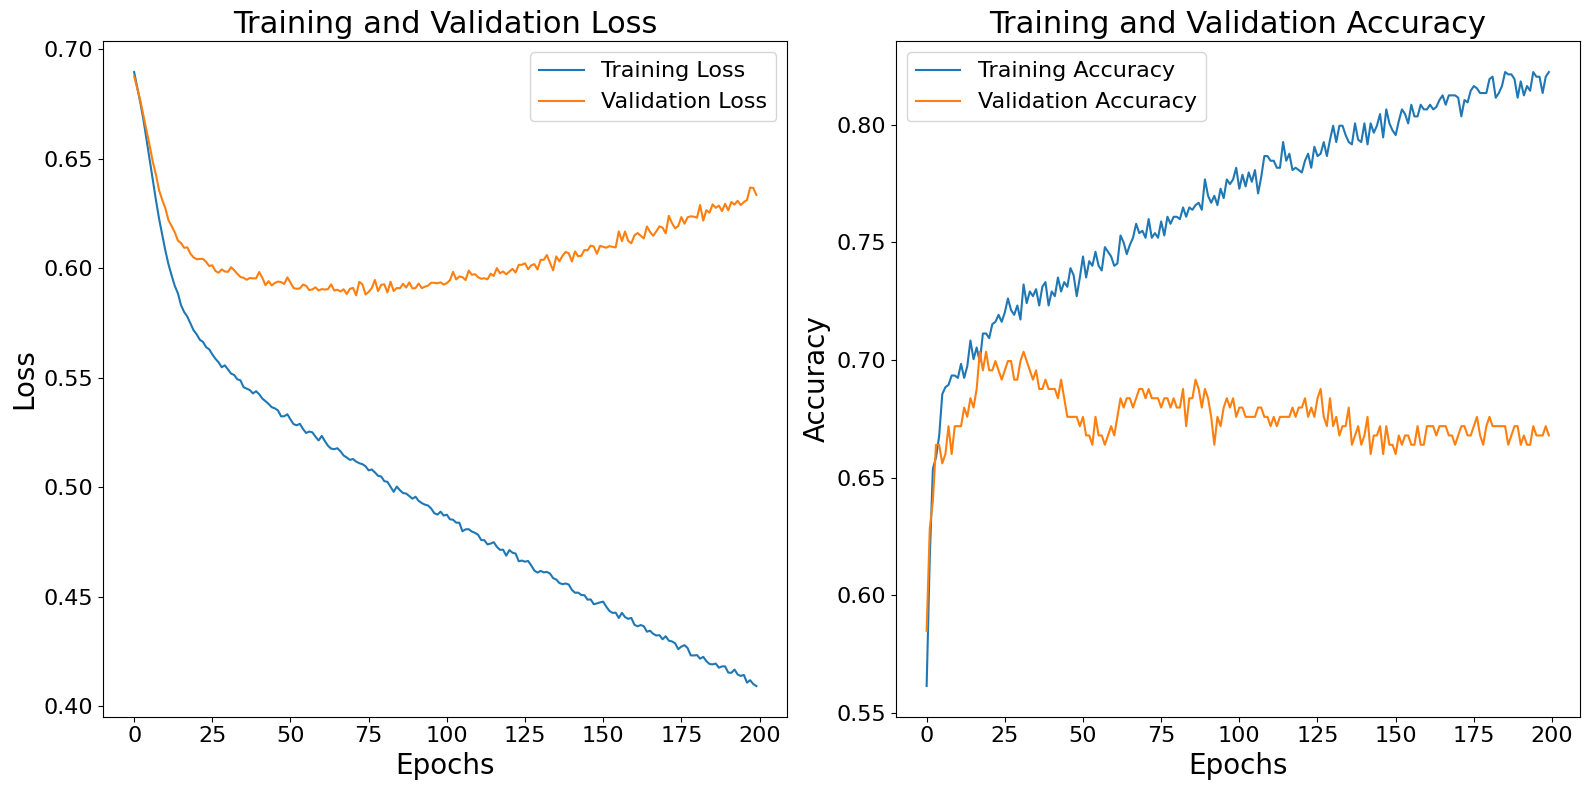

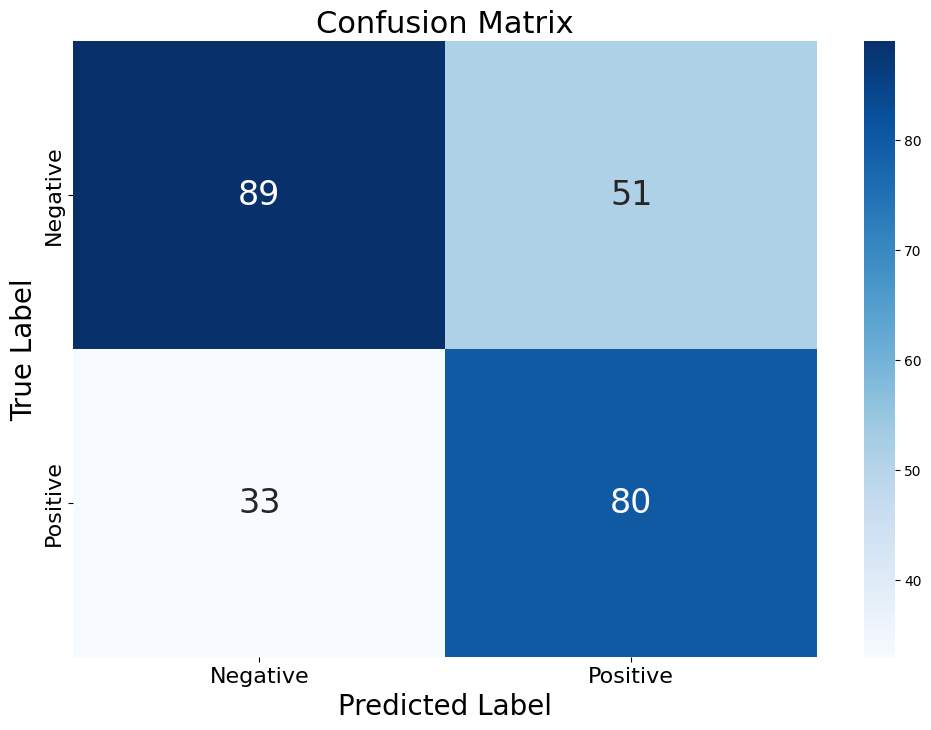


Métricas de Evaluación:
              precision    recall  f1-score   support

    Negative       0.73      0.64      0.68       140
    Positive       0.61      0.71      0.66       113

    accuracy                           0.67       253
   macro avg       0.67      0.67      0.67       253
weighted avg       0.68      0.67      0.67       253

Especificidad: 0.6357
Estadístico Kappa: 0.3385


: 

In [ ]:
# Código principal.
model, optimizer, loss_fn, device = setup_model()
num_epochs = 200
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(model,  train_dataloader,test_dataloader, optimizer, loss_fn, device, num_epochs)
plot_results(train_losses, val_losses, train_accuracies, val_accuracies)
evaluate_and_plot_confusion_matrix(model, test_dataloader, device)

### Pérdida de Entrenamiento y Validación
En esta gráfica, observamos que la **pérdida de entrenamiento** (línea azul) disminuye constantemente a lo largo de las épocas, lo que indica que el modelo está aprendiendo y ajustándose mejor a los datos de entrenamiento. Sin embargo, la **pérdida de validación** (línea naranja) muestra un comportamiento diferente. Aunque inicialmente disminuye, lo que es positivo, después comienza a aumentar gradualmente. Este incremento sugiere que el modelo está empezando a sobreajustarse a los datos de entrenamiento, lo cual significa que, aunque mejora en estos datos, su capacidad para generalizar a nuevos datos está disminuyendo.

### Precisión de Entrenamiento y Validación
La **precisión de entrenamiento** (línea azul) aumenta consistentemente, indicando que el modelo está aprendiendo a clasificar correctamente las secuencias de entrenamiento con el tiempo. Sin embargo, la **precisión de validación** (línea naranja) se estabiliza y fluctúa considerablemente después de las primeras épocas, lo que sugiere problemas de sobreajuste y una capacidad limitada del modelo para generalizar a los datos de validación.

### Mejoras Potenciales para el Modelo

Para mejorar el rendimiento del modelo, se pueden considerar varias estrategias: incrementar tasa de dropout para reducir el sobreajuste; ajustar hiperparámetros como la tasa de aprendizaje, el tamaño del lote, y el número de capas y neuronas en el modelo; utilizar un conjunto de datos más grande y diverso para mejorar la capacidad de generalización; aplicar técnicas de data augmentation para generar nuevas muestras sintéticas; o implementar validación cruzada para una evaluación más robusta del modelo. Estas mejoras pueden mitigar el sobreajuste y aumentar la capacidad del modelo para generalizar a nuevos datos.